In [12]:
import sys
sys.path.append('../src')
from preamble import *
figure_path = os.path.join(root_dir,'reports','figures')

# get data files
files_dict = walk_directory(raw_data)
drews_data = list(files_dict.keys())
drews_data.remove('pump')
drews_data.remove('Andrew_sleep') # not tracked

Andrew_diaper c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_diaper.csv
Andrew_expressed c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_expressed.csv
Andrew_formula c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_formula.csv
Andrew_growth c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_growth.csv
Andrew_milestone c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_milestone.csv
Andrew_nursing c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_nursing.csv
Andrew_other_activity c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_other_activity.csv
Andrew_sleep c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_sleep.csv
Andrew_temperature c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_temperature.csv
pump c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\pump.csv


In [13]:
from datetime import timedelta,datetime
def get_data(filename):
    return (pd.read_csv(filename)
             .drop(columns=['Baby'])
             .assign(Time= lambda x: pd.to_datetime(x.Time))
             .set_index('Time',drop=True))

def get_days_between(datePast, dateFuture):
   difference = dateFuture - datePast
   return difference.total_seconds() / timedelta(days=1).total_seconds()

In [14]:
# set date range for recent analysis
to_analyze = timedelta(days=7)
today = datetime.combine(datetime.now().date(), datetime.min.time())

def get_recent_filter(df):
    start_date = (df.index[-1] - to_analyze)
    analysis_flt = df.index > start_date
    return start_date,analysis_flt

## Diaper Habits

In [15]:
diaper_df = get_data(files_dict['Andrew_diaper'])
diaper_df['hour_of_day'] = [x.hour for x in diaper_df.index]
diaper_df = pd.concat((diaper_df,pd.get_dummies(diaper_df.Status)),axis=1)
diaper_df.Dirty = diaper_df.Dirty | diaper_df.Mixed
diaper_df.Wet = diaper_df.Wet | diaper_df.Mixed

start_date,analysis_flt = get_recent_filter(diaper_df)

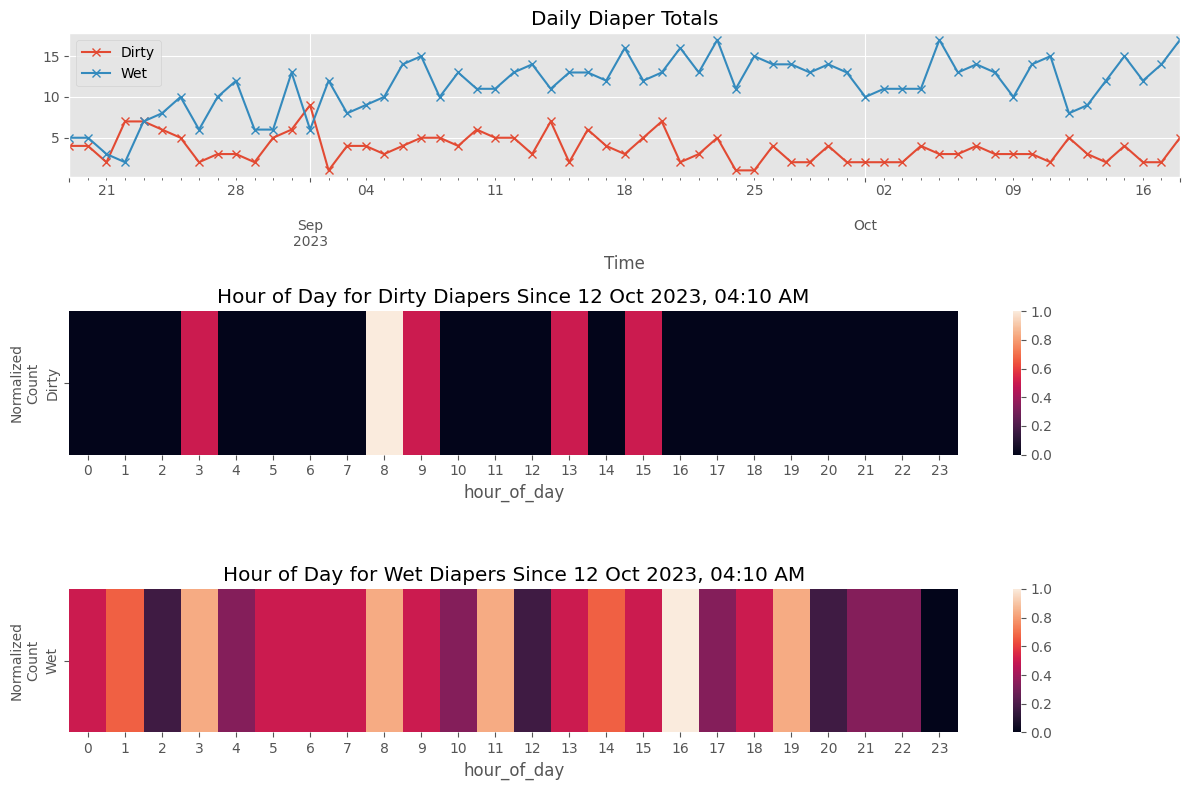

In [16]:
f,axes = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axes = axes.ravel()
ax = diaper_df[['Dirty','Wet']].resample('D').sum().iloc[:-1].plot(marker='x',ax=axes[0])
ax.set_title('Daily Diaper Totals')
for ax,status in zip(axes[1:],['Dirty','Wet']):
    tdf = diaper_df.loc[analysis_flt]
    tdf = tdf[tdf.Status == status].groupby('hour_of_day').sum().iloc[:-1]
    tdf[status] = tdf[status]/tdf[status].abs().max()
    tdf = tdf.reindex(list(range(0,24)),fill_value=0)
    ax = sns.heatmap(data=tdf[[status]].transpose(),vmin=0,vmax=1,ax=ax)
    ax.set_ylabel('Normalized\nCount',fontsize=10)
    s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
    ax.set_title(f'Hour of Day for {status} Diapers Since {s}')
plt.tight_layout()
plt.savefig(os.path.join(figure_path,'diapers.png'),bbox_inches='tight')

## Predict Return to Birth Weight

In [17]:
import statsmodels.api as sm

growth_df = get_data(files_dict['Andrew_growth'])
growth_df['days'] = [get_days_between(growth_df.index[0],x) for x in growth_df.index]
growth_df['sq_days'] = growth_df['days']*growth_df['days']
started_eating_filter = growth_df.days>2
model = sm.OLS(growth_df[started_eating_filter]['Weight (lbs.)'].values,
             sm.add_constant(growth_df[started_eating_filter][['days','sq_days']].values))
res = model.fit()
display(res.summary())
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]
growth_df['pred'] = np.append(np.full(sum(~started_eating_filter), fill_value=np.nan),res.fittedvalues)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     2424.
Date:                Thu, 19 Oct 2023   Prob (F-statistic):           2.27e-16
Time:                        09:17:58   Log-Likelihood:                 29.531
No. Observations:                  15   AIC:                            -53.06
Df Residuals:                      12   BIC:                            -50.94
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6917      0.025    106.895      0.000       2.637       2.747
x1             0.0405      0.002     16.657      0.000       0.035       0.046
x2          4.715e-05   4.31e-05      1.094      0.295   -4.67e-05       0.000
==============================================================================
Omnibus:                        1.293   Durbin-Watson:                   1.434
Prob(Omnibus):                  0.524   Jarque-Bera (JB):                0.806
Skew:                           0.117   Prob(JB):                        0.668
Kurtosis:                       1.889   Cond. No.                     2.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

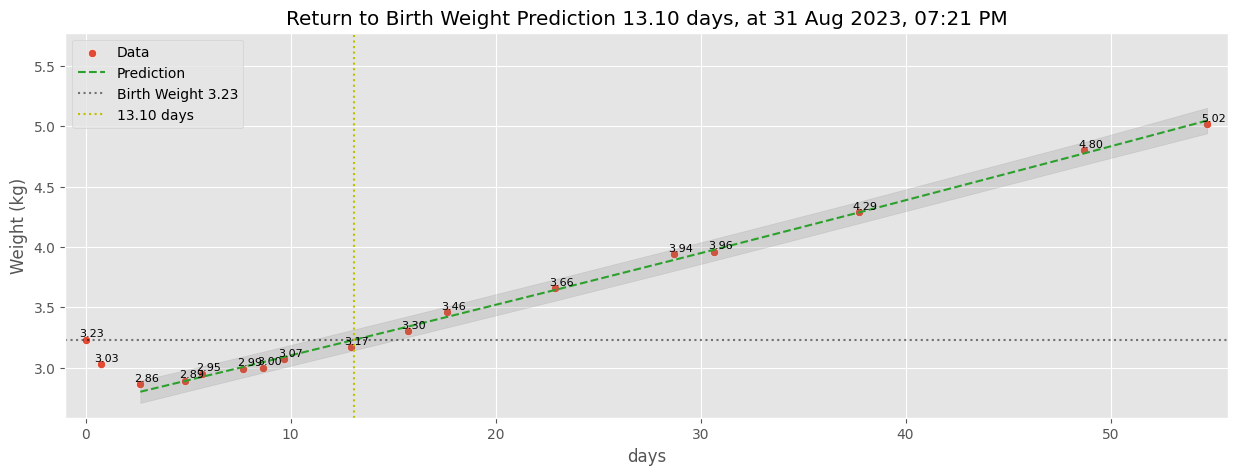

In [18]:
birth_weight = growth_df.at[growth_df.index[0],'Weight (lbs.)']
ax = sns.scatterplot(data=growth_df,x='days',y='Weight (lbs.)',label='Data')
ax = sns.lineplot(data=growth_df[started_eating_filter],x='days',y='pred',color='tab:green',
                  linestyle='dashed',label='Prediction')
ax.axhline(birth_weight,label=f'Birth Weight {birth_weight:0.2f}',color='k',linestyle='dotted',alpha=0.5)
ax.fill_between(growth_df[started_eating_filter].days,
    iv_l, iv_u, color='tab:gray', alpha=0.2)

return_to_birth_weight = np.max(np.roots(np.poly1d([res.params[2],res.params[1],res.params[0] - birth_weight])))
r2bw_date = growth_df.index[0] + timedelta(days=return_to_birth_weight)
r2bw_date = datetime.strftime(r2bw_date,'%d %b %Y, %I:%M %p')
ax.axvline(return_to_birth_weight,label = f'{return_to_birth_weight:0.2f} days',color='y',linestyle='dotted')
ax.set_title(f'Return to Birth Weight Prediction {return_to_birth_weight:0.2f} days, at {r2bw_date}')
yl = ax.get_ylim()
ax.set_xlim(-1,growth_df.at[growth_df.index[-1],'days']+1)
ax.set_ylim(yl[0],yl[1]+0.5)
for x, y in zip(growth_df.days, growth_df['Weight (lbs.)'].values):
    ax.text(x-0.3, y+0.025, f"{y:0.2f}", fontsize=8)
ax.set_ylabel('Weight (kg)')
ax.legend(loc='upper left')
_=plt.savefig(os.path.join(figure_path,'weight.png'),bbox_inches='tight')

## Feeding Habits

,Formula (oz.),Milk (oz.),Amount (oz.),Time Between Feeds (min)
count,80.000000,0.0,80.000000,80.000000
mean,2.392500,NaN,2.392500,126.437500
std,0.934301,NaN,0.934301,57.391139
min,0.500000,NaN,0.500000,30.000000
25%,2.000000,NaN,2.000000,90.000000
50%,2.250000,NaN,2.250000,117.500000
75%,3.000000,NaN,3.000000,140.000000
max,5.000000,NaN,5.000000,361.000000


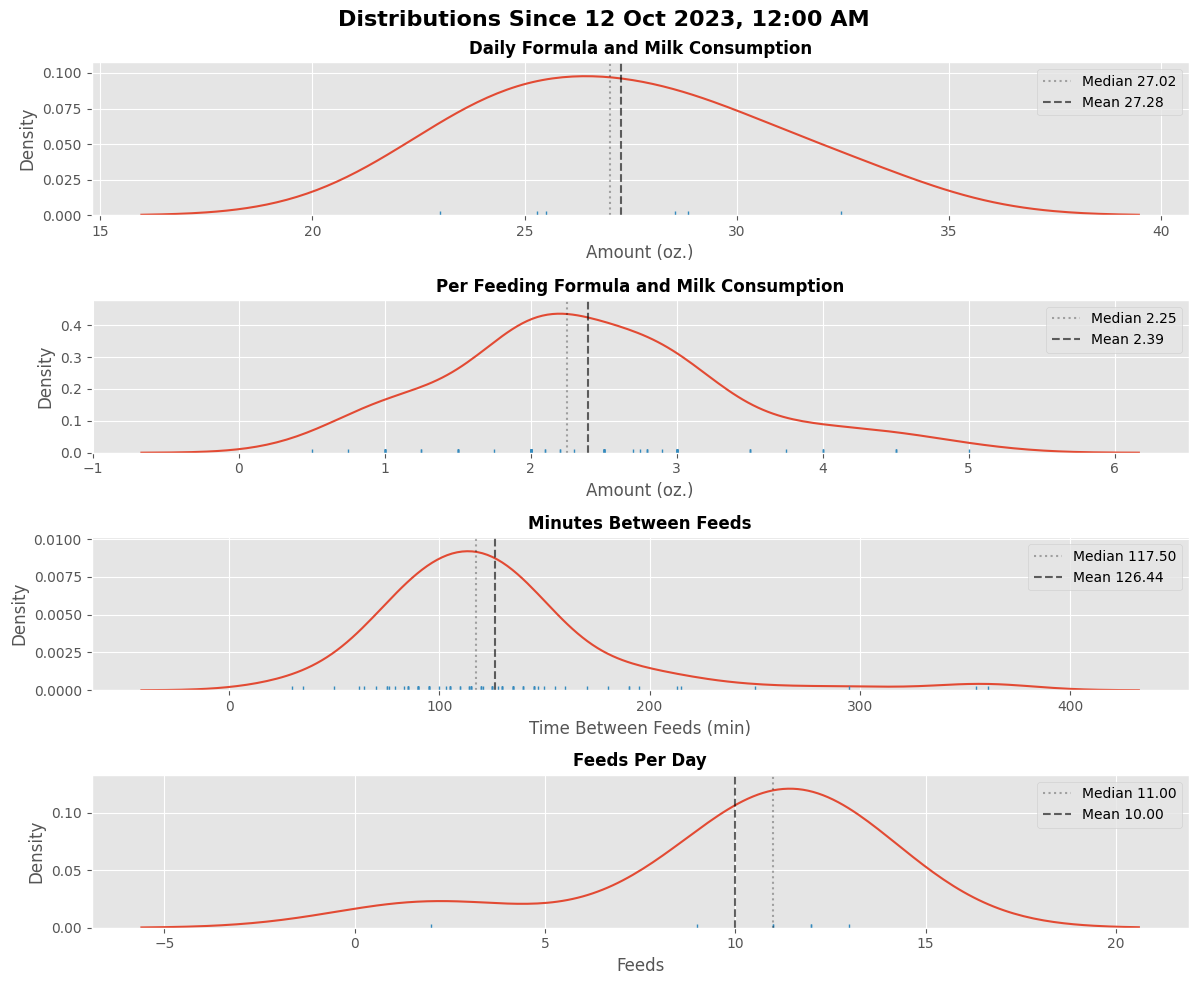

In [27]:
feeding_df = (pd.concat((get_data(files_dict['Andrew_formula']).rename(columns={'Amount (oz.)':'Formula (oz.)'}),
                        get_data(files_dict['Andrew_expressed']).rename(columns={'Amount (oz.)':'Milk (oz.)'})),axis=1)
                        .drop(columns=['Note'])
                        .assign(Amount = lambda x: x['Formula (oz.)'].fillna(x['Milk (oz.)']))
                        .rename(columns={'Amount':'Amount (oz.)'})
                        .sort_index())
start_date, analysis_flt = get_recent_filter(feeding_df)
feeding_df['hour_of_day'] = [x.hour for x in feeding_df.index]
feeding_df['Time Between Feeds (min)'] = feeding_df.index
feeding_df['Time Between Feeds (min)'] = feeding_df['Time Between Feeds (min)'].diff().fillna(timedelta(seconds=0))
feeding_df['Time Between Feeds (min)'] = feeding_df['Time Between Feeds (min)'].apply(lambda x: x.seconds//60)
feeding_df['Feeds'] = 0
feeding_df['Feeds'].loc[~feeding_df['Amount (oz.)'].isna()] = 1
tdf = feeding_df.resample('D').sum()[['Amount (oz.)']]
ts,tf = get_recent_filter(tdf)
tdf = tdf.loc[tf & (tdf.index<today)]

# analyze recent data
feeding_df['rolling mean amount'] = feeding_df['Amount (oz.)'].rolling(to_analyze).mean()
feeding_df['rolling median amount'] = feeding_df['Amount (oz.)'].rolling(to_analyze).median()

feeding_df['rolling mean time between feeds'] = feeding_df['Time Between Feeds (min)'].rolling(to_analyze).mean()
feeding_df['rolling median time between feeds'] = feeding_df['Time Between Feeds (min)'].rolling(to_analyze).median()

stats = feeding_df.loc[analysis_flt].describe()
display(stats[['Formula (oz.)','Milk (oz.)','Amount (oz.)','Time Between Feeds (min)']])
mean = stats.at['mean','Amount (oz.)']
median = stats.at['50%','Amount (oz.)']
mean_time = stats.at['mean','Time Between Feeds (min)']
median_time = stats.at['50%','Time Between Feeds (min)']
mean_total = tdf.describe().at['mean','Amount (oz.)']
median_total = tdf.describe().at['50%','Amount (oz.)']

# plot
f,axes = plt.subplots(ncols=1,nrows=4,figsize=(12,10))
ax0,ax1,ax2,ax3 = axes.ravel()
ax=sns.kdeplot(data=tdf,x='Amount (oz.)',ax=ax0)
ax=sns.rugplot(data=tdf,x='Amount (oz.)',ax=ax)
ax.axvline(median_total,color='k',linestyle='dotted',label=f'Median {median_total:0.2f}',alpha=0.3)
ax.axvline(mean_total,color='k',linestyle='dashed',label=f'Mean {mean_total:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Daily Formula and Milk Consumption',fontweight='bold',fontsize=12)

ax=sns.kdeplot(data=feeding_df.loc[analysis_flt],x='Amount (oz.)',ax=ax1)
ax=sns.rugplot(data=feeding_df.loc[analysis_flt],x='Amount (oz.)',ax=ax)
ax.axvline(median,color='k',linestyle='dotted',label=f'Median {median:0.2f}',alpha=0.3)
ax.axvline(mean,color='k',linestyle='dashed',label=f'Mean {mean:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Per Feeding Formula and Milk Consumption',fontweight='bold',fontsize=12)

ax=sns.kdeplot(data=feeding_df.loc[analysis_flt],x='Time Between Feeds (min)',ax=ax2)
ax=sns.rugplot(data=feeding_df.loc[analysis_flt],x='Time Between Feeds (min)',ax=ax)
ax.axvline(median_time,color='k',linestyle='dotted',label=f'Median {median_time:0.2f}',alpha=0.3)
ax.axvline(mean_time,color='k',linestyle='dashed',label=f'Mean {mean_time:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Minutes Between Feeds',fontweight='bold',fontsize=12)


daily_feeds_df = feeding_df.resample('D').sum()
daily_feeds_df['rolling mean feeds per day'] = daily_feeds_df['Feeds'].rolling(to_analyze).mean()
daily_feeds_df['rolling median feeds per day'] = daily_feeds_df['Feeds'].rolling(to_analyze).median()
start_date,analysis_flt = get_recent_filter(daily_feeds_df)
mean_feeds = daily_feeds_df.loc[analysis_flt].Feeds.mean()
median_feeds = daily_feeds_df.loc[analysis_flt].Feeds.median()
ax=sns.kdeplot(data=daily_feeds_df.loc[analysis_flt],x='Feeds',ax=ax3)
ax=sns.rugplot(data=daily_feeds_df.loc[analysis_flt],x='Feeds',ax=ax)
ax.axvline(median_feeds,color='k',linestyle='dotted',label=f'Median {median_feeds:0.2f}',alpha=0.3)
ax.axvline(mean_feeds,color='k',linestyle='dashed',label=f'Mean {mean_feeds:0.2f}',alpha=0.6)
ax.legend()
s = datetime.strftime(start_date,'%d %b %Y, %I:%M %p')
ax.set_title(f'Feeds Per Day',fontweight='bold',fontsize=12)

plt.suptitle(f'Distributions Since {s}',fontweight='bold',fontsize=16)
plt.tight_layout()

_=plt.savefig(os.path.join(figure_path,'feeding_distribution.png'),bbox_inches='tight')

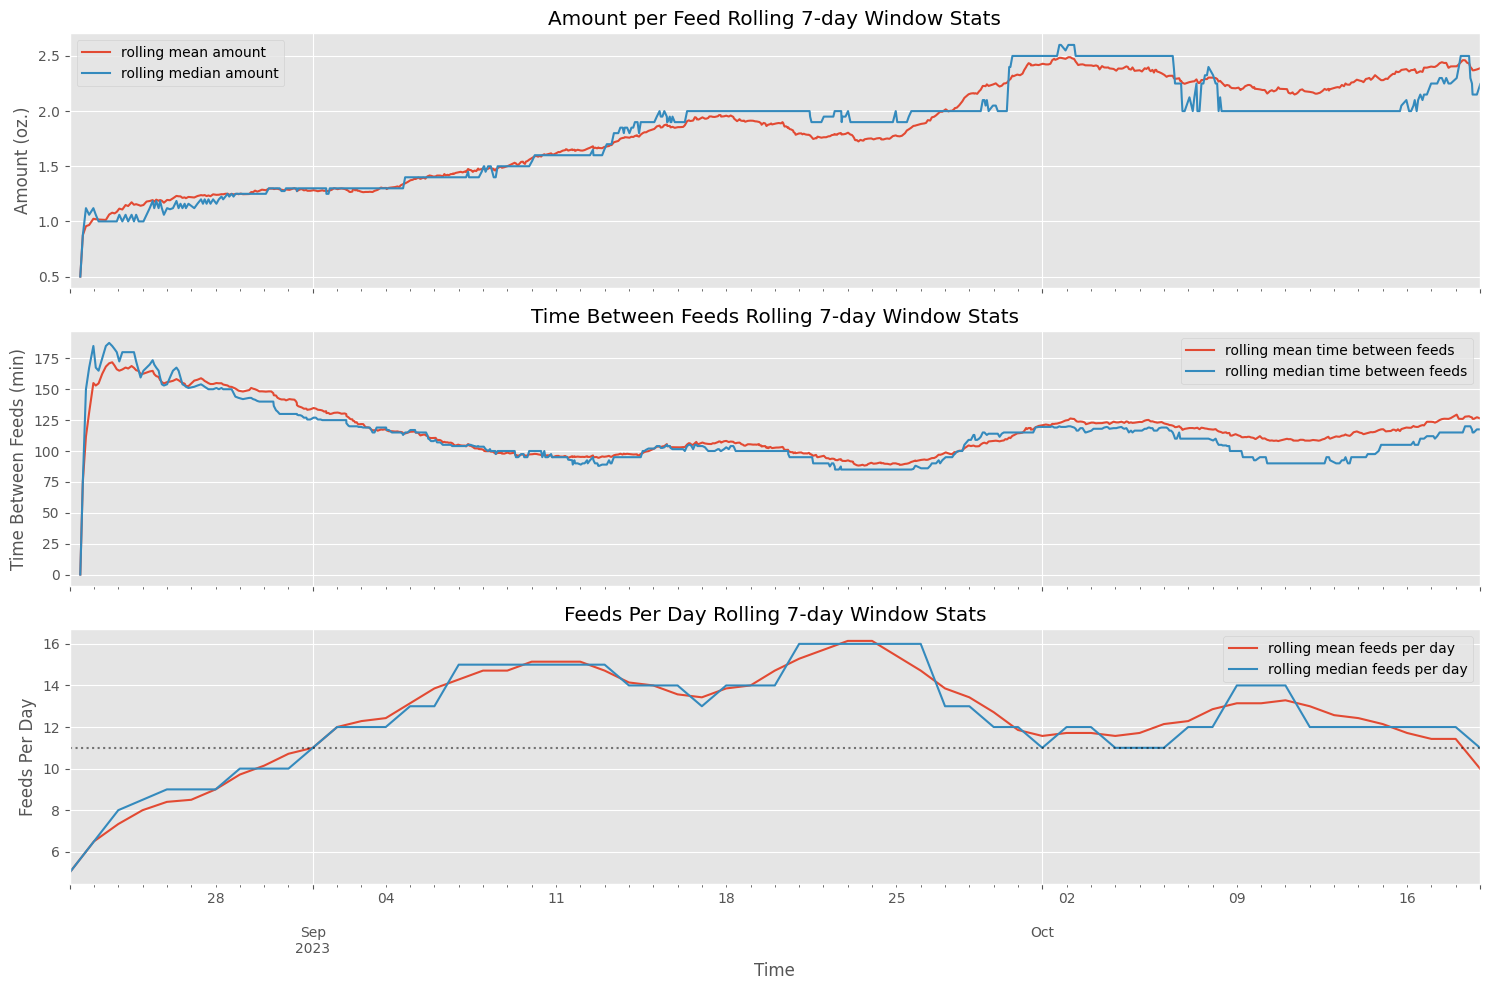

In [20]:
f,axes = plt.subplots(ncols=1,nrows=3,figsize=(15,10),sharex=True)
ax1,ax2,ax3 = axes.ravel()
ax = feeding_df[['rolling mean amount','rolling median amount']].dropna().plot(ax=ax1)
ax.set_ylabel('Amount (oz.)')
ax.set_title(f'Amount per Feed Rolling {to_analyze.days}-day Window Stats')

ax = feeding_df[['rolling mean time between feeds','rolling median time between feeds']].dropna().plot(ax=ax2)
ax.set_ylabel('Time Between Feeds (min)')
ax.set_title(f'Time Between Feeds Rolling {to_analyze.days}-day Window Stats')

ax = daily_feeds_df[['rolling mean feeds per day','rolling median feeds per day']].dropna().plot(ax=ax3)
ax.axhline(11,label='Scheduled Target',linestyle='dotted',color='k',alpha=0.5)
ax.set_ylabel('Feeds Per Day')
ax.set_title(f'Feeds Per Day Rolling {to_analyze.days}-day Window Stats')
plt.tight_layout()
_=plt.savefig(os.path.join(figure_path,'feeding_rolling.png'),bbox_inches='tight')

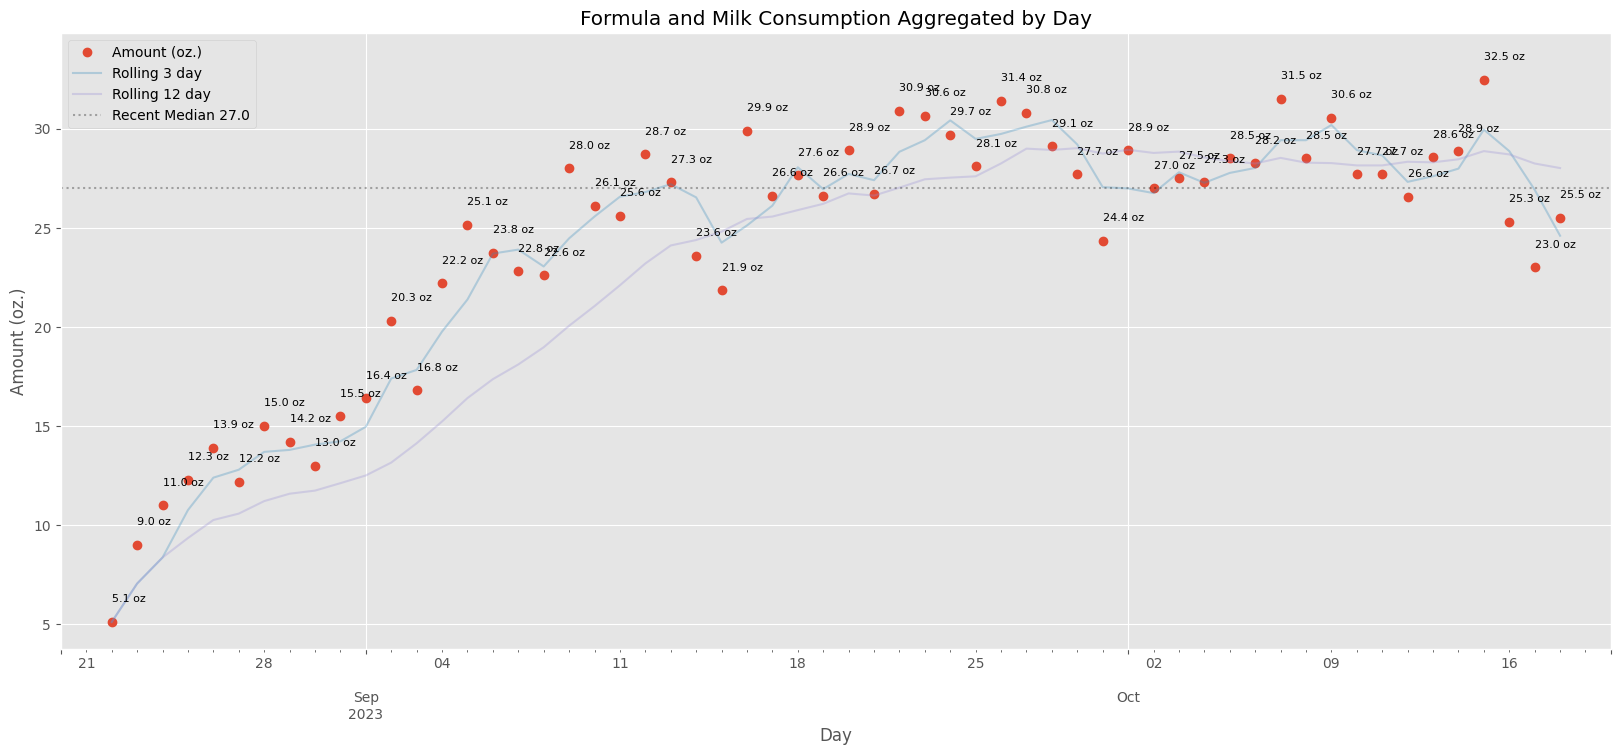

In [23]:
tdf = feeding_df.resample('D').sum()[['Amount (oz.)']]
tdf['Rolling 3 day'] = tdf['Amount (oz.)'].rolling('3D').mean()
tdf['Rolling 12 day'] = tdf['Amount (oz.)'].rolling('12D').mean()
tdf = pd.DataFrame(tdf.loc[tdf.index<today]) # drop incomplete day
tdf['x'] = range(1,len(tdf.index)+1)
ax = tdf['Amount (oz.)'].plot(marker='o',linestyle='none',figsize=(20,8))
ax = tdf[['Rolling 3 day','Rolling 12 day']].fillna(method='backfill').plot(ax=ax,alpha=0.3)
ax.set_xlim(tdf.index[0]-timedelta(days=2),tdf.index[-1]+timedelta(days=2))
yl = ax.get_ylim()
offset = 1.0
ax.set_ylim(yl[0],yl[1]+offset)
for x, y in zip(tdf.index, tdf['Amount (oz.)'].values):
    ax.text(x, y+offset, f"{y:0.1f} oz", fontsize=8)
ax.axhline(median_total,label=f'Recent Median {median_total:0.1f}',linestyle='dotted',color='k',alpha=0.3)
ax.set_ylabel('Amount (oz.)')
ax.set_xlabel('Day')
ax.legend(loc='upper left')
ax.set_title('Formula and Milk Consumption Aggregated by Day')
_=plt.savefig(os.path.join(figure_path,'feeding_daily_totals.png'),bbox_inches='tight')

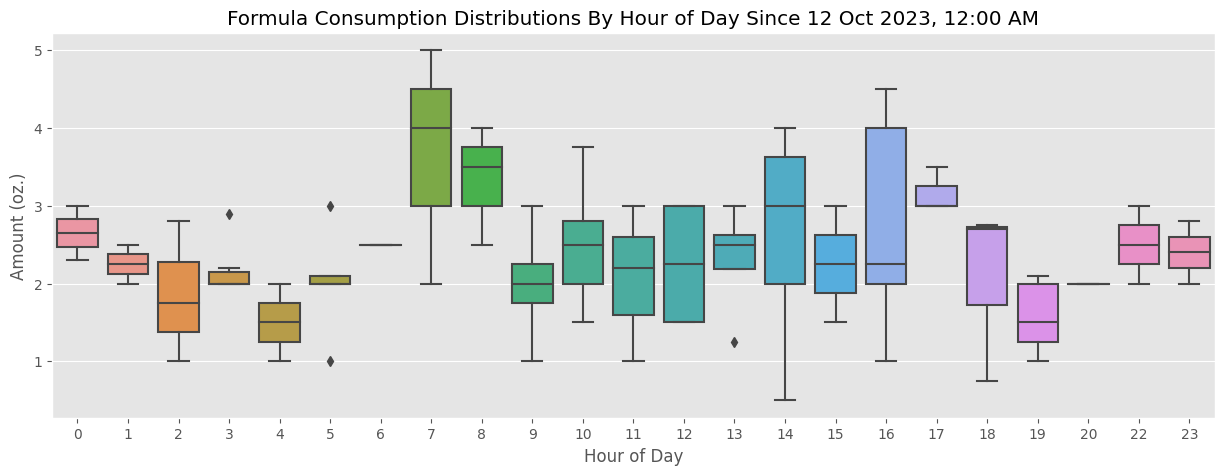

In [22]:
start_date,analysis_flt = get_recent_filter(feeding_df)
ax=sns.boxplot(data=feeding_df.loc[analysis_flt],y='Amount (oz.)',x='hour_of_day')
ax.set_title(f'Formula Consumption Distributions By Hour of Day Since {s}')
ax.set_xlabel('Hour of Day')
_=plt.savefig(os.path.join(figure_path,'feeding_by_hour.png'),bbox_inches='tight')